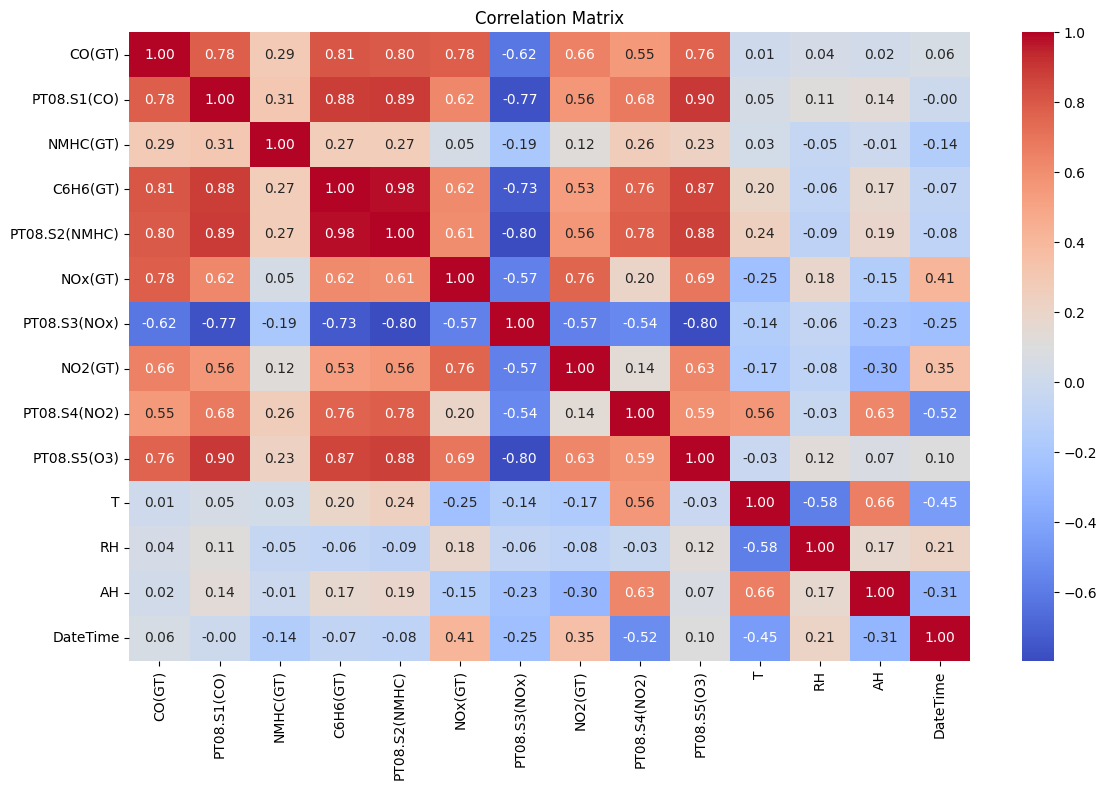

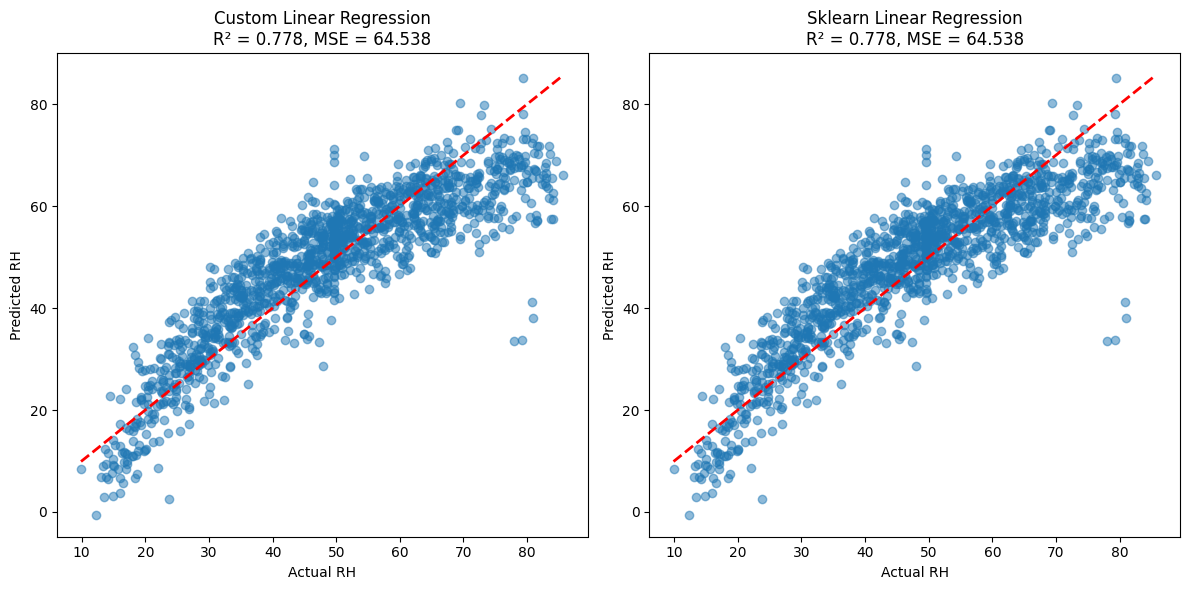


Model Comparison:
Custom Linear Regression - R² Score: 0.778, MSE: 64.538
Sklearn Linear Regression - R² Score: 0.778, MSE: 64.538

Feature Importance:
          Feature  Coefficient
0          CO(GT)    -1.876317
10              T    -1.824178
7         NO2(GT)    -0.118202
3        C6H6(GT)    -0.081475
4   PT08.S2(NMHC)    -0.075582
8    PT08.S4(NO2)     0.057135
5         NOx(GT)     0.039676
6    PT08.S3(NOx)    -0.028966
2        NMHC(GT)    -0.013859
1     PT08.S1(CO)     0.005956
9     PT08.S5(O3)     0.003045


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
def preprocess_data(df):
    # Convert Date and Time columns to datetime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df.drop(['Date', 'Time'], axis=1)
    
    # Handle missing values (tagged as -200)
    df = df.replace(-200, np.nan)
    
    # Fill missing values with median of respective columns
    for column in df.columns:
        if df[column].isnull().any():
            df[column] = df[column].fillna(df[column].median())
    
    return df

# Custom Linear Regression implementation
class CustomLinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None
    
    def fit(self, X, y):
        # Add column of ones for intercept
        X_with_intercept = np.column_stack([np.ones(len(X)), X])
        
        # Calculate coefficients using normal equation
        coeffs = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
        
        self.intercept = coeffs[0]
        self.coefficients = coeffs[1:]
    
    def predict(self, X):
        return X @ self.coefficients + self.intercept

# Load and preprocess data
df = pd.read_csv('AirQualityUCIcsv.csv', delimiter=',', decimal='.')
df = preprocess_data(df)

# Generate correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()

# Prepare features and target
X = df.drop(['DateTime', 'RH', 'AH'], axis=1)  # Remove DateTime, target (RH), and AH
y = df['RH']

# Split the data (85:15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Train custom linear regression model
custom_model = CustomLinearRegression()
custom_model.fit(X_train.values, y_train.values)
custom_predictions = custom_model.predict(X_test.values)

# Train sklearn linear regression model
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
sklearn_predictions = sklearn_model.predict(X_test)

# Calculate metrics
custom_r2 = r2_score(y_test, custom_predictions)
custom_mse = mean_squared_error(y_test, custom_predictions)
sklearn_r2 = r2_score(y_test, sklearn_predictions)
sklearn_mse = mean_squared_error(y_test, sklearn_predictions)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, custom_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RH')
plt.ylabel('Predicted RH')
plt.title('Custom Linear Regression\nR² = {:.3f}, MSE = {:.3f}'.format(custom_r2, custom_mse))

plt.subplot(1, 2, 2)
plt.scatter(y_test, sklearn_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RH')
plt.ylabel('Predicted RH')
plt.title('Sklearn Linear Regression\nR² = {:.3f}, MSE = {:.3f}'.format(sklearn_r2, sklearn_mse))

plt.tight_layout()
plt.show()
plt.savefig('regression_comparison.png')
plt.close()

# Print comparison results
print("\nModel Comparison:")
print(f"Custom Linear Regression - R² Score: {custom_r2:.3f}, MSE: {custom_mse:.3f}")
print(f"Sklearn Linear Regression - R² Score: {sklearn_r2:.3f}, MSE: {sklearn_mse:.3f}")

# Print feature importance for sklearn model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': sklearn_model.coef_
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False))